# Simulation of Complex Systems - Chapter 12
**Author**: Artur Gasparyan

In [51]:
need_upgrade = False
if need_upgrade:
    !pip install --upgrade matplotlib
    !pip install --upgrade networkx

In [52]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

seed = 69420
np.random.seed(seed)
rng = np.random.default_rng(seed)

# Exercise 12.1

In [53]:
def generate_er_edges(n_nodes, p_edge):
    edges = np.zeros((n_nodes, n_nodes))
    
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if rng.random() < p_edge:
                edges[[i, j], [j, i]] = 1
                
        
    return edges

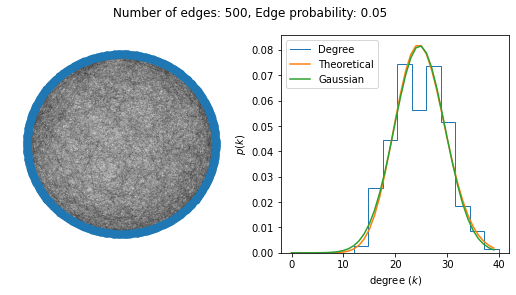

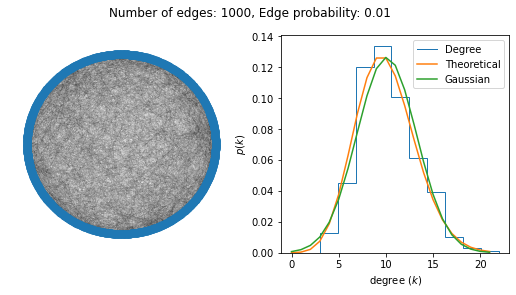

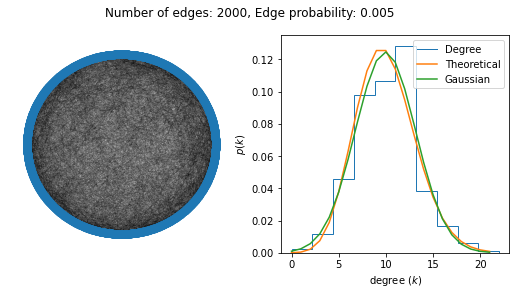

In [54]:
n_nodes_all = [500, 1000, 2000]
p_edge_all = [0.05, 0.01, 0.005]
n_tests = len(n_nodes_all)


for i in range(n_tests):
    n_nodes = n_nodes_all[i]
    p_edge = p_edge_all[i]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(f"Number of edges: {n_nodes}, Edge probability: {p_edge}")
    ax2.set_xlabel(r"degree ($k$)")
    ax2.set_ylabel(r"$p(k)$")

    edges = generate_er_edges(n_nodes, p_edge)
    er_graph = nx.Graph(edges)
    nb_counts = np.sum(edges, axis=0)
    
    counts, bins = np.histogram(nb_counts, density=True)
    n_bins = len(bins)
    last_bin = math.ceil(max(bins))
    
    nb_count_theory = np.zeros(last_bin)
    for k in range(last_bin):
        nb_count_theory[k] = math.comb(n_nodes-1, k) * (p_edge**k) * ((1-p_edge)**(n_nodes-1-k))
        
    gaussian = np.zeros(last_bin)
    count_std = np.std(nb_counts)
    count_mean = np.mean(nb_counts)
    for k in range(last_bin):
        gaussian[k] = math.exp(-0.5*((k-count_mean)/count_std)**2)/(count_std*math.sqrt(2*math.pi))
        
    nx.draw_circular(er_graph, ax=ax1, node_size=50, width=0.02)
    ax2.stairs(counts, bins)
    ax2.plot(np.arange(last_bin), nb_count_theory)
    ax2.plot(np.arange(last_bin), gaussian)
    
    ax2.legend(["Degree", "Theoretical", "Gaussian"])


# Exercise 12.2

In [55]:
def generate_ws_edges(n_nodes, n_nb, p_rewire):
    assert n_nb % 2 == 0
    
    edges = np.zeros((n_nodes, n_nodes))

    half_range = n_nb // 2
    
    for i in range(n_nodes):
        for j in range(-half_range, half_range+1):
            if j == 0:
                continue
            
            k = (i+j) % n_nodes
                
                
            edges[k, i] = 1
            edges[i, k] = 1
            
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if edges[i, j] == 0:
                continue
                
            if rng.random() < p_rewire:                
                edges[i, j] = 0
                edges[j, i] = 0
                
                alternatives = np.nonzero(edges[i, :]==0)[0]
                alternatives = alternatives[alternatives != i]
                r = rng.choice(alternatives)
                
                edges[r, i] = 1
                edges[i, r] = 1
        
    return edges

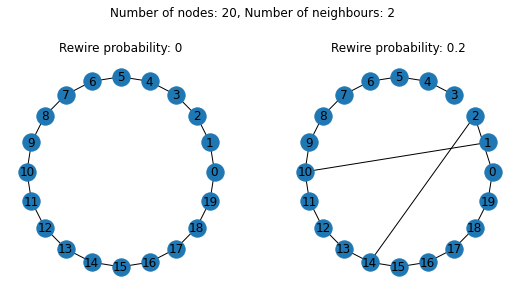

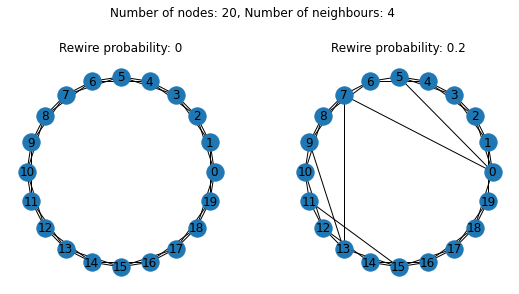

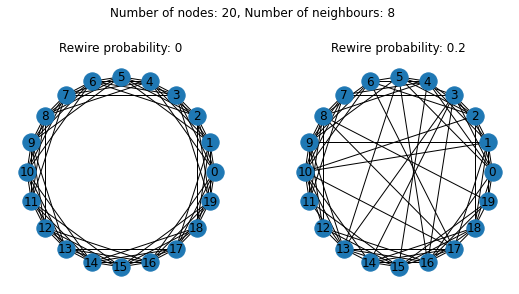

In [56]:
n_nodes = 20
n_nbs_all = [2, 4, 8]
p_rewire = 0.2

for n_nbs in n_nbs_all:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
    fig.suptitle(f"Number of nodes: {n_nodes}, Number of neighbours: {n_nbs}")
    fig.tight_layout(pad=2)
    ax1.set_title(f"Rewire probability: {0}")
    ax2.set_title(f"Rewire probability: {p_rewire}")

    ws_edges_norewire = generate_ws_edges(n_nodes, n_nbs, 0)
    ws_edges_rewire = generate_ws_edges(n_nodes, n_nbs, p_rewire)
    
    assert(ws_edges_norewire.sum() == ws_edges_rewire.sum())
    
    ws_graph_norewire = nx.Graph(ws_edges_norewire)
    ws_graph_rewire = nx.Graph(ws_edges_rewire) 
    
    nx.draw_circular(ws_graph_norewire, with_labels=True, ax=ax1)
    nx.draw_circular(ws_graph_rewire, with_labels=True, ax=ax2)


## Exercise 12.3

In [57]:
def generate_ab_edges(n_nodes, n_connections, n_nodes_start):
    assert n_nodes >= n_nodes_start > n_connections
    
    edges = np.zeros((n_nodes, n_nodes))
    edges[:n_nodes_start, :n_nodes_start] = 1
    edges[np.identity(n_nodes).astype(bool)]=0
    
    for n in range(n_nodes_start, n_nodes):
        degrees = np.sum(edges[:n, :n], axis=1)
        p_choice = degrees/np.sum(degrees)
        i_connections = rng.choice(n, size=n_connections, p=p_choice, replace=False)
        edges[n, i_connections] = 1
        edges[i_connections, n] = 1
        
    return edges

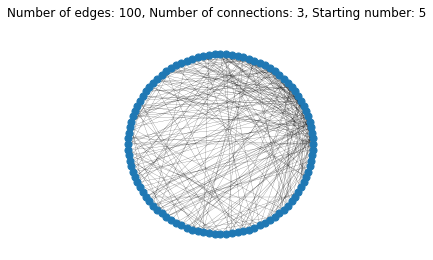

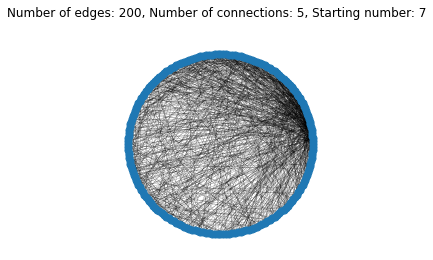

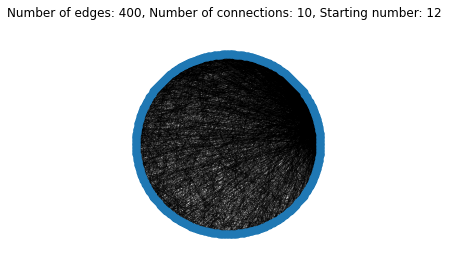

In [58]:
n_nodes_all = [100, 200, 400]
n_connections_all = [3, 5, 10]
n_nodes_start_all = [5, 7, 12]
n_tests = len(n_nodes_all)


for i in range(n_tests):
    n_nodes = n_nodes_all[i]
    n_connections = n_connections_all[i]
    n_nodes_start = n_nodes_start_all[i]
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
    fig.suptitle(f"Number of edges: {n_nodes}, Number of connections: {n_connections}, Starting number: {n_nodes_start}")

    edges = generate_ab_edges(n_nodes, n_connections, n_nodes_start)
    ab_graph = nx.Graph(edges)

    nx.draw_circular(ab_graph, node_size=50, width=0.15)

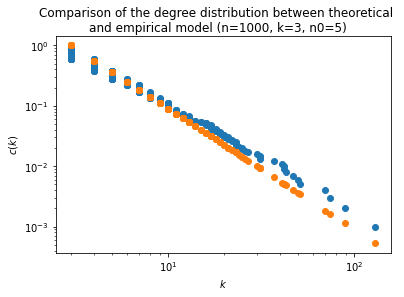

In [59]:
n_nodes = 1000
n_conn = 3
n_start = 5

edges = generate_ab_edges(n_nodes, n_conn, n_start)
degrees = np.sort(np.sum(edges, axis=1))[::-1]
lin_arr = np.arange(1, n_nodes+1)/n_nodes
deg_theory = n_conn**2 * degrees**-2

fig = plt.figure()
fig.suptitle(f"Comparison of the degree distribution between "
             f"theoretical \nand empirical model (n={n_nodes}, k={n_conn}, n0={n_start})")
ax = fig.gca()
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$c(k)$")
ax.set_xscale("log")
ax.set_yscale("log")
plt.scatter(degrees, lin_arr)
plt.scatter(degrees, deg_theory)

...;

## Exercise 12.4

In [101]:
def compute_lengths(edges):
    n_nodes = edges.shape[0]
    lengths = -np.ones((n_nodes, n_nodes))
    lengths[np.identity(n_nodes, 'bool')] = 0
    
    t = 1
    a_t = edges
    
    while -1 in lengths:
        # Since the graph is acyclic, every node will be visited once at most.
        # Therefore, maximum number of iterations is n. 
        # If the iterations exceed that, we are in a loop.
        if t > n_nodes:
            break
                        
        lengths[(a_t != 0) & (lengths == -1)] = t
        
        t += 1
        a_t = a_t @ edges
    
    return lengths


def compute_average_lengths(lengths):
    return np.mean(lengths[lengths>0])


def compute_cluster_coef(edges):
    n_nodes = edges.shape[0]
    degrees = np.sum(edges, axis=1)
    numerator = np.sum(np.diag(edges @ edges @ edges))
    denomenator = np.sum(degrees*(degrees-1))
    return numerator/denomenator

In [61]:
import warnings
warnings.filterwarnings('ignore')

n_nodes = 500
p_edge_all = [0.015, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9]


avg_lengths_all = []
cluster_coef_all = []

for p_edge in p_edge_all:
    edges = generate_er_edges(n_nodes, p_edge)
    
    lengths = compute_lengths(edges)
        
    avg_lengths = compute_average_lengths(lengths)
    cluster_coef = compute_cluster_coef(edges)
    
    avg_lengths_all.append(avg_lengths)
    cluster_coef_all.append(cluster_coef)
    

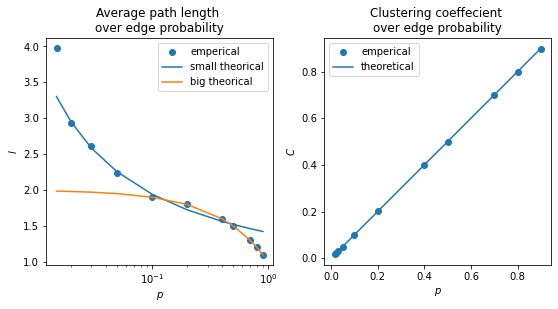

In [62]:
p_edge = np.array(p_edge_all)

em_const = 0.57722
small_theory = (np.log(n_nodes)-em_const)/(np.log(p_edge*(n_nodes-1))) + 0.5
big_theory = 2 - p_edge
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=2)

ax1.set_xscale('log')
ax1.scatter(p_edge, avg_lengths_all)
ax1.plot(p_edge, small_theory)
ax1.plot(p_edge, big_theory)
ax1.legend(["emperical", "small theorical", "big theorical"])
ax1.set_title("Average path length \nover edge probability")
ax1.set_xlabel(r"$p$")
ax1.set_ylabel(r"$l$")

ax2.scatter(p_edge, cluster_coef_all)
ax2.plot(p_edge, p_edge)
ax2.legend(["emperical", "theoretical"])
ax2.set_title("Clustering coeffecient \nover edge probability")
ax2.set_xlabel(r"$p$")
ax2.set_ylabel(r"$C$")

...;

## Exercise 12.5

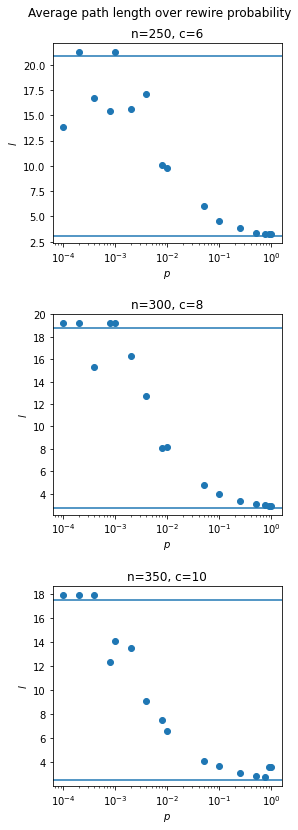

In [63]:
n_nodes_all = [250, 300, 350]
n_nbs_all = [6, 8, 10]
p_rewire_all = [0.0001, 0.0002, 0.0004, 0.0008, 0.001, 0.002, 0.004, 0.008, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
n_tests = len(n_nodes_all)
fig, axes = plt.subplots(n_tests, 1, figsize=(5, 4*n_tests))
fig.tight_layout(pad=5)
fig.suptitle("Average path length over rewire probability")

for test in range(n_tests):
    n_nodes = n_nodes_all[test]
    n_nbs = n_nbs_all[test]

    theory_min = n_nodes/(2*n_nbs)
    theory_max = np.log(n_nodes)/np.log(n_nbs)
    
    avg_lengths_all = []

    for p_rewire in p_rewire_all:
        edges = generate_ws_edges(n_nodes, n_nbs, p_rewire)
        lengths = compute_lengths(edges)
        avg_lengths = compute_average_lengths(lengths)
        avg_lengths_all.append(avg_lengths)
        
    p_rewire = np.array(p_rewire_all)

    ax = axes[test]
    ax.scatter(p_rewire, avg_lengths_all)
    ax.axhline(y=theory_min)
    ax.axhline(y=theory_max)
    ax.set_xscale('log')
    ax.set_title(f"n={n_nodes}, c={n_nbs}")
    ax.set_xlabel(r"$p$")
    ax.set_ylabel(r"$l$")

...;

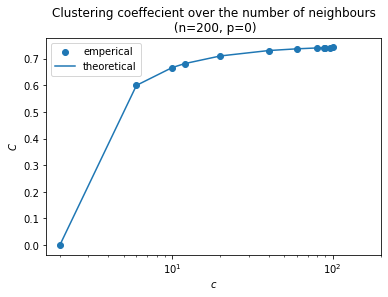

In [64]:
n_nodes = 200
n_nbs_all = [2, 6, 10, 12, 20, 40, 60, 80, 88, 90, 96, 100]

cluster_coef_all = []

for n_nbs in n_nbs_all:
    edges = generate_ws_edges(n_nodes, n_nbs, 0)
    cluster_coef = compute_cluster_coef(edges)
    cluster_coef_all.append(cluster_coef)
    
n_nbs = np.array(n_nbs_all)
cluster_coef = np.array(cluster_coef_all)
limit_theory = 0.75*(n_nbs - 2)/(n_nbs - 1)

fig = plt.figure()
ax = fig.gca()

plt.scatter(n_nbs, cluster_coef)
plt.plot(n_nbs, limit_theory)

ax.set_xscale('log')
ax.set_xlim(0, 200)
ax.set_xlabel(r'$c$')
ax.set_ylabel(r'$C$')
ax.set_title(f'Clustering coeffecient over the number of neighbours\n (n={n_nodes}, p=0)')
ax.legend(['emperical', 'theoretical'])

...;

## Exercise 12.6

In [107]:
def generate_ab_edges_with_average_lengths(n_nodes, n_connections, n_nodes_start):
    assert n_nodes >= n_nodes_start > n_connections
    
    edges = np.zeros((n_nodes, n_nodes))
    edges[:n_nodes_start, :n_nodes_start] = 1
    edges[np.identity(n_nodes).astype(bool)]=0

    lengths = compute_lengths(edges[:n_nodes_start+1, :n_nodes_start+1])
    avg_lengths = [compute_average_lengths(lengths)]
    
    for n in range(n_nodes_start, n_nodes):
        degrees = np.sum(edges[:n, :n], axis=1)
        p_choice = degrees/np.sum(degrees)
        i_connections = rng.choice(n, size=n_connections, p=p_choice, replace=False)
        edges[n, i_connections] = 1
        edges[i_connections, n] = 1
        
        lengths = compute_lengths(edges[:n+1, :n+1])
        avg_length = compute_average_lengths(lengths)
        avg_lengths.append(avg_length)
        
    return edges, avg_lengths

Test nr: 0
Test nr: 1
Test nr: 2


Text(0.5, 1.0, 'Average path length over number of nodes')

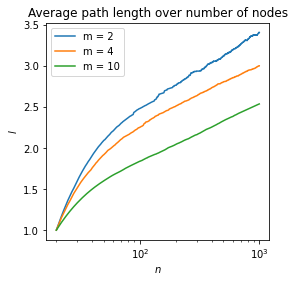

In [145]:
n_nodes = 1000
n_connections_all = [2, 4, 10]
n_starting = 20
n_tests = len(n_connections_all)

ab_edges_all = []
avg_lengths_all = []

for test in range(n_tests):
    print(f"Test nr: {test}")
    n_connections = n_connections_all[test]
    
    ab_edges, avg_lengths = generate_ab_edges_with_average_lengths(n_nodes, n_connections, n_starting)
    
    ab_edges_all.append(ab_edges)
    avg_lengths_all.append(avg_lengths)
    
    
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()

for test in range(n_tests):    
    n_connections = n_connections_all[test]
    
    avg_lengths = avg_lengths_all[test]
    ab_edges = ab_edges_all[test]
    
    ax.plot(np.arange(n_starting, n_nodes+1), avg_lengths)
    
ax.legend([f"m = {n_conn}" for n_conn in n_connections_all])
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$l$")
ax.set_xscale('log')
ax.set_title("Average path length over number of nodes")

(0.0, 0.25)

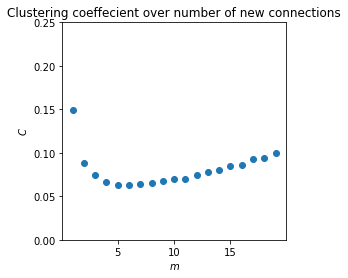

In [149]:
n_nodes = 1000
n_starting = 20
n_connections_all = list(range(1, 20))

ab_edge_list = [generate_ab_edges(n_nodes, n_connections, n_starting) for n_connections in n_connections_all]
cluster_coef = np.array(list(compute_cluster_coef(edges) for edges in ab_edge_list))

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
ax.set_title("Clustering coeffecient over number of new connections")
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$C$")
ax.scatter(n_connections_all, cluster_coef)
ax.set_ylim(0,  0.25)

## Finalizing

In [150]:
save_pdf = True
if save_pdf:
    !pip install nbconvert[webpdf] -q
    !jupyter nbconvert --to webpdf --allow-chromium-download chapter-12.ipynb

[NbConvertApp] Converting notebook chapter-12.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 678013 bytes to chapter-12.pdf
